# Materials and code to create images of the LORA paper's annex (CPU / time usage)

In [1]:
%matplotlib inline
from pylab import *

In [2]:
rcParams['figure.figsize'] = (8,8)

In [3]:
import os
import glob

import pandas as pd
import seaborn as sns
from tqdm import tqdm
from sequana import *

In [4]:
import importlib
import utils  # your module
importlib.reload(utils)

<module 'utils' from '/home/cokelaer/Work/1_Projects/LORA/paper_LORA/utils.py'>

# Timing and memory

In [5]:
dfs = []
from tqdm import tqdm
for x in [
    "bacteroide_fragilis",
    "cyanobacteria",
    "leishmania",
    "streptococcus",
    "veillonella_ccs",
    "veillonella_raw"]:
    
    methods = glob.glob(f"metadata_resources/{x}/*")
    
    for method in methods:
        try:
            df = pd.read_csv(f"{method}/slurm_stats.txt")
            method = method.split("/")[-1]
            df['exp'] = x

            df['circlator'] = False if 'nocirc' in method else True

            
            if method == 'lora':
                df['assembler'] = 'canu'
                df['circlator'] = True
            elif method in ['lora_polish_paired', 'lora_polish_SE']:  
                df['assembler'] = 'flye'
            else:
                name = method.split("_")[0]
                df['assembler'] = name
            dfs.append(df)
        except:
            print(method)


dfs = pd.concat(dfs)
dfs['cpu_time_seconds'] = [utils.to_seconds(x) for x in dfs['cpu_time'].values]
dfs['time_seconds'] = [utils.to_seconds(x) for x in dfs['time'].values]
dfs

metadata_resources/cyanobacteria/hifiasm_circ
metadata_resources/cyanobacteria/hifiasm_nocirc
metadata_resources/cyanobacteria/pecat_circ
metadata_resources/cyanobacteria/unicycler_circ
metadata_resources/cyanobacteria/unicycler_nocirc
metadata_resources/leishmania/canu
metadata_resources/leishmania/hifiasm
metadata_resources/veillonella_raw/hifiasm_circ
metadata_resources/veillonella_raw/hifiasm_nocirc


,task,memory_gb,thread,time,cpu_time,exp,circlator,assembler,cpu_time_seconds,time_seconds
0,bam2bed,3.009937,4,00:01:02,00:04:08,cyanobacteria,True,canu,248,62
1,busco,0.558689,4,00:00:27,00:01:48,cyanobacteria,True,canu,108,27
2,canu,6.983616,1,02:42:46,02:42:46,cyanobacteria,True,canu,9766,9766
3,checkm,1.079258,4,00:02:10,00:08:40,cyanobacteria,True,canu,520,130
4,checkm_marker,0.420620,1,00:00:10,00:00:10,cyanobacteria,True,canu,10,10
...,...,...,...,...,...,...,...,...,...,...
9,quast,3.999504,4,00:06:08,00:24:32,veillonella_raw,False,unicycler,1472,368
10,seqkit_sort,0.121189,4,00:00:03,00:00:12,veillonella_raw,False,unicycler,12,3
11,sequana_coverage,1.632362,1,00:01:37,00:01:37,veillonella_raw,False,unicycler,97,97
12,unicycler,15.999413,8,00:01:49,00:14:32,veillonella_raw,False,unicycler,872,109


# cleanup of pecat/necat and build simplified dataframe


In [6]:
columns = ['exp', 'assembler', 'circlator']
tokeep = ['cpu_time_seconds']
dd_cpu_times = pd.concat([
    dfs.query("task in ['necat_bridge', 'necat_assemble', 'necat_correct']").groupby(columns).sum()[tokeep].reset_index(),
    dfs.query("task in ['pecat_correct', 'pecat_assemble']").groupby(columns).sum()[tokeep].reset_index(),
    dfs.query("task in ['hifiasm']").groupby(columns).sum()[tokeep].reset_index(),
    dfs.query("task in ['unicycler']").groupby(columns).sum()[tokeep].reset_index(),
    dfs.query("task in ['canu']").groupby(columns).sum()[tokeep].reset_index(),
    dfs.query("task in ['flye']").groupby(columns).sum()[tokeep].reset_index()])

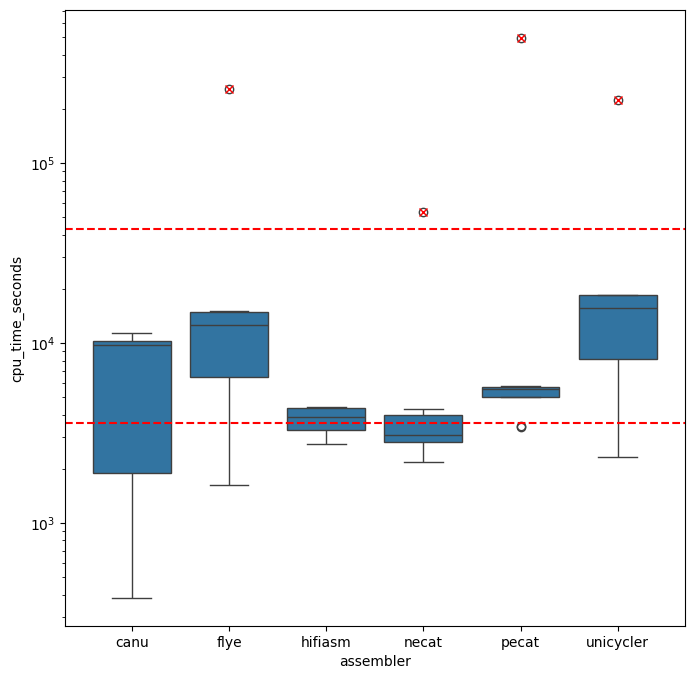

In [7]:

sns.boxplot(
    data=dd_cpu_times,
    x='assembler',
    y='cpu_time_seconds', 
    order=["canu", "flye", "hifiasm", "necat", "pecat", "unicycler"]
)
gca().set_yscale("log")
axhline(3600, ls='--', color='r')
axhline(3600*12, ls='--', color='r')

plot([1,3,4,5], [259000, 53588, 498360, 223872], 'xr')
show()

In [8]:
columns = ['exp', 'assembler', 'circlator']
tokeep = ['memory_gb']
dd_memory = pd.concat([
    dfs.query("task in ['necat_bridge', 'necat_assemble', 'necat_correct']").groupby(columns).max()[tokeep].reset_index(),
    dfs.query("task in ['pecat_correct', 'pecat_assemble']").groupby(columns).max()[tokeep].reset_index(),
    dfs.query("task in ['hifiasm']").groupby(columns).max()[tokeep].reset_index(),
    dfs.query("task in ['unicycler']").groupby(columns).max()[tokeep].reset_index(),
    dfs.query("task in ['canu']").groupby(columns).max()[tokeep].reset_index(),
    dfs.query("task in ['flye']").groupby(columns).max()[tokeep].reset_index()])

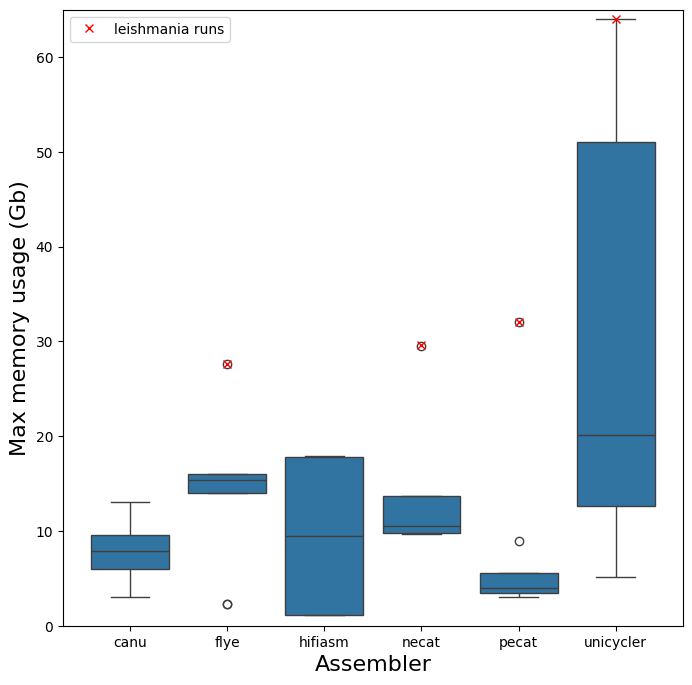

In [9]:
sns.boxplot(
    data=dd_memory,
    x='assembler',
    y='memory_gb', 
    order=["canu", "flye", "hifiasm", "necat", "pecat", "unicycler"]
)
ax = gca()
ax.set_xlabel("Assembler", fontsize=16)            # new label for the x-axis
ax.set_ylabel("Max memory usage (Gb)", fontsize=16)  
plot([1,3,4,5], [27.6, 29.6,32, 64], 'xr', label="leishmania runs")
legend()
_ = ylim([0, 65])

In [10]:
dd_merge = pd.merge(dd_cpu_times, dd_memory, on=columns)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


💾 Saved paper_images/figure_memory_time_versus_experiment.eps in pdf/eps/png


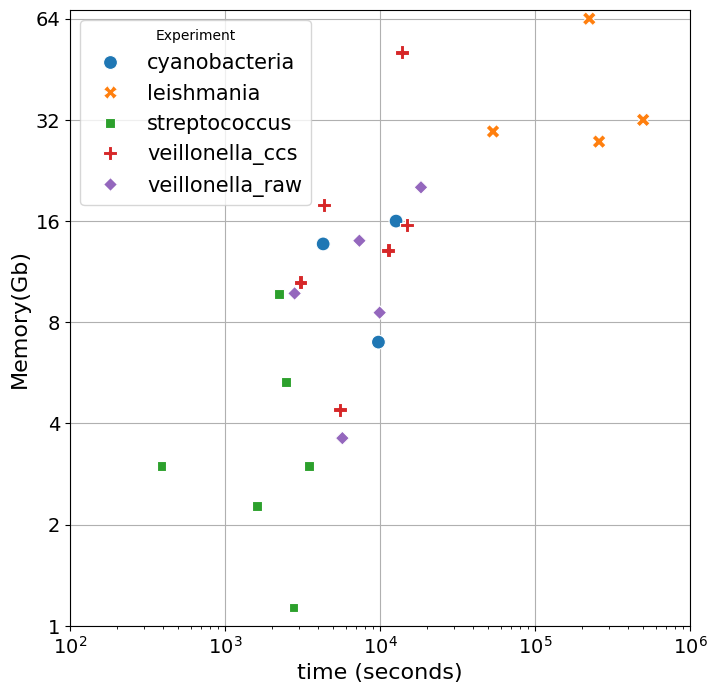

In [11]:
rcParams["figure.figsize"] = (8,8)

sns.scatterplot(
    data=dd_merge.query("circlator == True"),
    x="cpu_time_seconds",
    y="memory_gb",
    hue="exp",      # or hue="assembler"
    style="exp",
    s=100,
    zorder=10
)
semilogx()
semilogy()
xlabel("time (seconds)", fontsize=16)
ylabel("Memory(Gb)", fontsize=16)
_ = legend(title="Experiment", fontsize=15, loc="upper left")
tick_params(axis="both", labelsize=14)   # 14 pt tick labels
gca().set_yscale("log", base=2)   # <-- base=2
grid()
ylim([1,68])
xlim([100,1e6])
yticks([1,2,4,8,16,32,64
    ],[1,2,4,8,16,32,64])
utils.saveall("paper_images/figure_memory_time_versus_experiment")



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


💾 Saved paper_images/figure_memory_time_versus_assembler.eps in pdf/eps/png


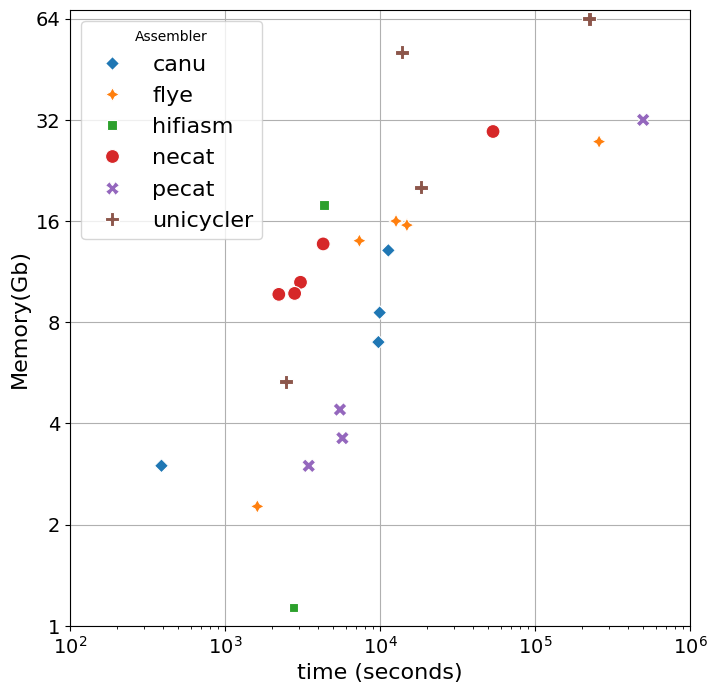

In [12]:
rcParams["figure.figsize"] = (8,8)
sns.scatterplot(
    data=dd_merge.query("circlator == True"),
    x="cpu_time_seconds",
    y="memory_gb",
    hue="assembler",      # or hue="assembler"
    style="assembler",      # optional: use markers for assembler
    s=100,
    zorder=10,
    hue_order = ['canu','flye','hifiasm','necat','pecat','unicycler'],
    #markers={'canu':'o'},
    )
semilogx()
semilogy()
xlabel("time (seconds)", fontsize=16)
ylabel("Memory(Gb)", fontsize=16)
legend(title="Assembler", fontsize=16, loc="upper left")
tick_params(axis="both", labelsize=14)   # 14 pt tick labels
ylim([1,68])
xlim([100,1e6])
gca().set_yscale("log", base=2)   # <-- base=2
yticks([1,2,4,8,16,32,64
    ],[1,2,4,8,16,32,64])
grid()
utils.saveall("paper_images/figure_memory_time_versus_assembler")


## distribution time. canu, then circlator and ccs 

💾 Saved paper_images/pie_chart_1.eps in pdf/eps/png
💾 Saved paper_images/pie_chart_2.eps in pdf/eps/png


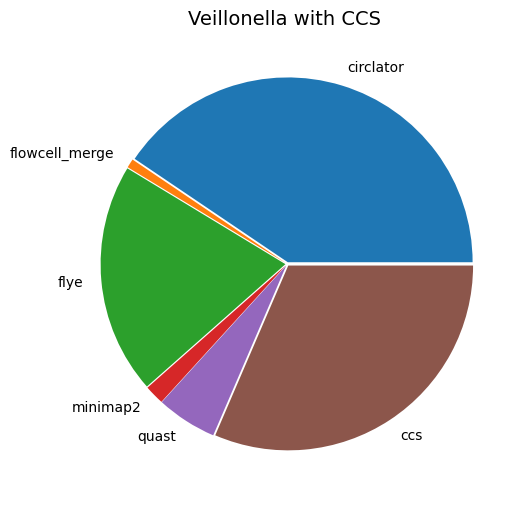

In [13]:
rcParams["figure.figsize"] = (6,6)
data = dfs.query("cpu_time_seconds>=120 and assembler=='flye' and circlator == True and exp=='leishmania'")
tasks = data.task.values

_ = pie(data['cpu_time_seconds'].values, labels=tasks,explode=[0.01]*len(tasks))
_ = title("Leishmania -- no CCS, no circularisation", fontsize=14)
utils.saveall("paper_images/pie_chart_1")

clf()
data = dfs.query("time_seconds>120 and assembler=='flye' and circlator == True and exp=='veillonella_ccs'")
# merge the CCS tasks
mask = data["task"] == "ccs"
summed_row = pd.DataFrame([{"task": "ccs", "cpu_time_seconds": data.loc[mask, "cpu_time_seconds"].sum()}])
data = pd.concat([data.loc[~mask], summed_row], ignore_index=True)
tasks = data.task.values
_ = pie(data['cpu_time_seconds'].values, labels=tasks, explode=[0.01]*len(tasks))
_ = title("Veillonella with CCS ", fontsize=14)
utils.saveall("paper_images/pie_chart_2")

